# Data Wrangling with SQL
## Map Area - Mountain View, California

### Aviad Giat - Data Analyst Nano Degree Program, Udacity

I chose to do this project on the city of Mountain View, CA, where I currently live with my wife and two kids. I believe I will be able to learn more about my city using this dataset. I will be inspecting the OSM (XML) file to get a glimpse of how the dataset looks like, including sample lists of the street names, users contributing to the map in the city and what kind of street types we have in Mountain View.
After inspecting, I will audit the OSM file, find issues with the street names and zip codes that will potentially make the analysis results inaccurate, correct the issues with Python before converting the clean data to the tabular format, CSV.
CSV files will be used to create data structures, which will then be used in a SQL database.
I will do my analysis of the city on this SQL database.

#### About MV
The California city of Mountain View, situated between the San Francisco Bay and the Santa Cruz Mountains, lies 10 miles north of San Jose and 35 miles south of San Francisco. Neighbouring cities include Palo Alto, Los Altos, and Sunnyvale. The city has 80,000 residents and its spread over 12 square miles.

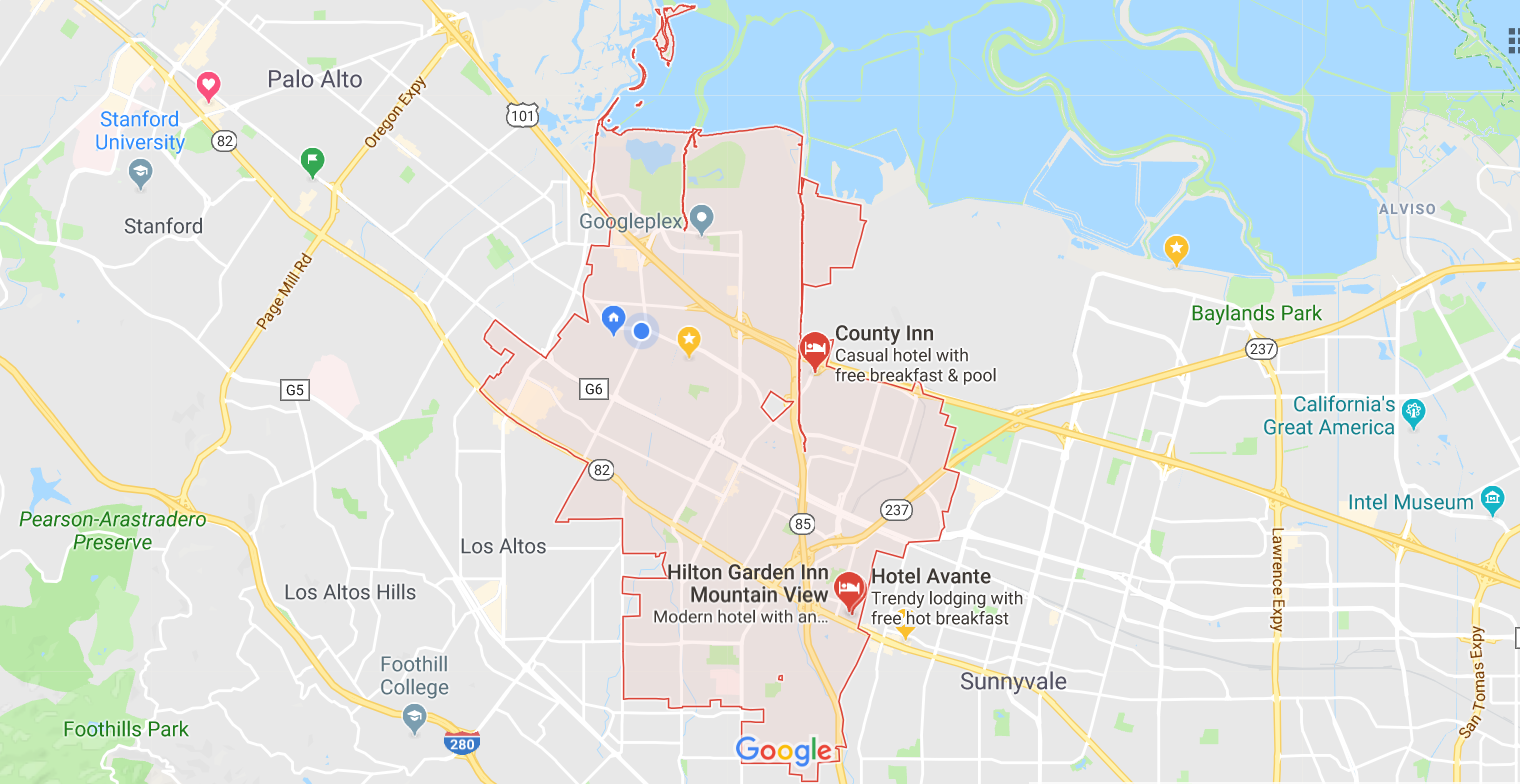

In [178]:
from IPython.display import Image
Image(filename='mountain_view.png')

<a id="top" name=""></a>
# Index
1. <a href="#inspect">Inspect the XML file</a>
2. <a href="#audit1">Audit the street names</a>
3. <a href="#problems1">Problems found and solutions for the wrong street names</a>
4. <a href="#improve1">Improve the street names</a>
5. <a href="#audit2">Audit the zip codes</a>
6. <a href="#problems2">Problems found and solutions for the zip codes</a>
7. <a href="#improve2">improve the zip codes</a>
8. <a href="#export_csv">Export the data to CSV files</a>
9. <a href="#create_sql">Create the SQL database</a>
10. <a href="#read_csv">Read the data from the CSV files</a>
11. <a href="#insert_data_sql">Insert the data into the SQL database</a>
12. <a href="#import_check">Check if the data was imported correctly to the SQL database</a>
13. <a href="#improve_sql">Improve data with SQL</a>
14. <a href="#analyze_sql">Analyze the data using SQL</a>
15. <a href="#analyze_pandas">Analyze the data using Pandas</a>
16. <a href="#conclusion">Conclusion</a>

In [179]:
%%html
<style>.output_wrapper, .output {height:auto !important; max-height:1000px;
                                }.output_scroll {box-shadow:none !important; webkit-box-shadow:none !important;}</style>

In [180]:
import xml.etree.cElementTree as ET
import re
import pprint

<a id="inspect" name="inspect"></a><br />
# Inspect the Open Street Map file
<a href="#top">Top</a>

## Find all top level tags

In [181]:
# Parsing through the dataset and finding all top level tags

tree = ET.parse('mountain-view.osm')
root = tree.getroot()
tagslist = []
for elem in root.iter():
    tagslist.append(elem.tag)
tagslist = list(set(tagslist))
print(tagslist)

['node', 'member', 'meta', 'osm', 'tag', 'relation', 'way', 'nd', 'note', 'bounds']


## Count the number of appearences of each tag

In [182]:
# Count the tags

def count_tags(filename):
    tag_count = {} #create dictionary
    for _, element in ET.iterparse(filename, events=("start",)): #  iterate and parse and ignore the index
        add_tag(element.tag, tag_count)
    return tag_count

def add_tag(tag, tag_count):
    if tag in tag_count:
        tag_count[tag] += 1
    else:
        tag_count[tag] = 1

def execute():
    tags = count_tags('mountain-view.osm')
    pprint.pprint(tags)

if __name__ == "__main__":
     execute()

{'bounds': 1,
 'member': 10737,
 'meta': 1,
 'nd': 339312,
 'node': 291999,
 'note': 1,
 'osm': 1,
 'relation': 422,
 'tag': 111838,
 'way': 37291}


## Separate tags to types (lower, lower with colon ':', problemchars)
Checking the 'k' value of the tags. There are three regular expression, lower is for tags that contain only lowercase letters and are valid. lower_colon is for other valid tags with a colon in the value. problemchars is for tags with problematic characters. Finally I obtain a dictionary which contains the count of each of three tag categories above.

In [183]:
# Tag Types (lower, lower with colon ':', problematic charachters)

import xml.etree.cElementTree as ET
import pprint
import re

lower = re.compile(r'^([a-z]|_)*$')
lower_colon = re.compile(r'^([a-z]|_)*:([a-z]|_)*$')
problemchars = re.compile(r'[=\+/&<>;\'"\?%#$@\,\. \t\r\n]')

def key_type(element, keys):
    if element.tag == "tag":
        if re.search(problemchars, element.attrib['k']):
            keys['problemchars'] += 1
        elif re.search(lower_colon, element.attrib['k']):
            keys['lower_colon'] += 1
        elif re.search(lower, element.attrib['k']):
            keys['lower'] += 1
        else:
            keys['other'] += 1
    return keys

def process_map(filename):
    keys = {"lower": 0, "lower_colon": 0, "problemchars": 0, "other": 0}
    for _, element in ET.iterparse(filename):
        keys = key_type(element, keys)
    return keys

def keys():
    keys = process_map('mountain-view.osm')
    pprint.pprint(keys)


if __name__ == "__main__":
    keys()

{'lower': 70357, 'lower_colon': 39986, 'other': 1470, 'problemchars': 25}


## Find the number of contributing users and random 10 names

In [184]:
# Number of contributing users
import random
import itertools

def process_users(filename):
    users = []
    for _, element in ET.iterparse(filename):
        if "user" in element.attrib:
            users.append(element.attrib["user"])
    return users

def mv_users():
    users = process_users('mountain-view.osm')
    print('Number of users:')
    pprint.pprint(len(set(users))) # Set is bringing unique Ids, and len count occurrences
    
#     print('\n10 first names\n--------------') # Print the first 10 names instead of random names
#     for i, val in enumerate(itertools.islice(users, 10)):
#         print(i, val)

    print('\n10 random user names\n---------------------')
    count = 0
    random.shuffle(users)
    for elem in iter(users):
        count = count + 1
        if count == 10:
            break
        print(elem)
        
#     print('\nAll user\ns--------------\n')
#     print(users) # Show all users

if __name__ == "__main__":
    mv_users()

Number of users:
537

10 random user names
---------------------
Rub21
dannykath
n76
Harry Cutts
ErikPottinger
Harry Cutts
StellanL
ediyes
doug_sfba


## Find 20 random street names

In [185]:
# Find the number of streets and the names of the first 10
import random

def is_street_name(elem):
    return (elem.attrib['k'] == "addr:street")

def process_map(filename):
    streets = []
    unique_streets = set()
    for _, element in ET.iterparse(filename):
        if element.tag == "tag":
            if element.attrib['k'] == "addr:street":
                streets.append(element.attrib["v"])
                unique_streets.add(element.attrib["v"])
    return streets
    return unique_streets


def mv_streets():
    streets = process_map('mountain-view.osm')
    unique_streets = process_map('mountain-view.osm')
    count = 0
    print('Number of times streets mentioned in the dataset:')
    pprint.pprint(len(streets))
    print('\nNumber of unique streets in the dataset:')
    pprint.pprint(len(set(unique_streets)))
    print('\n10 random street names\n---------------------')
    random.shuffle(streets)
    for elem in iter(streets):
        count = count + 1
        if count == 10:
            break
        print(elem)
        
if __name__ == "__main__":
    mv_streets()

Number of times streets mentioned in the dataset:
8404

Number of unique streets in the dataset:
452

10 random street names
---------------------
Thompson Avenue
Springer Terrace
Nantucket Court
Jamestown Drive
Mardell Way
Rock Street
West Knickerbocker Drive
Latham Street
Seena Avenue


## Find all street type

In [186]:
# Find all street type

import xml.etree.cElementTree as ET
from collections import defaultdict
import re
import pprint

OSM_FILE = "mountain-view.osm"
street_type_re = re.compile(r'\b\S+\.?$', re.IGNORECASE)

expected = []

def audit_street_type(street_types, street_name):
    """Audit the type of a street name and add to a street_type set"""
    m = street_type_re.search(street_name)
    if m:
        street_type = m.group() 
        if street_type not in expected:
            street_types[street_type].add(street_name)

def is_street_name(elem):
    """Check if elem is a street name"""
    return (elem.attrib['k'] == "addr:street")

def audit(osmfile):
    """Return a dict of street_types and street_name from an osmfile"""
    osm_file = open(osmfile, "r", encoding="utf8")
    street_types = defaultdict(set)
    for event, elem in ET.iterparse(osm_file, events=("start",)):
        if elem.tag == "node" or elem.tag == "way": #only check way and node
            for tag in elem.iter("tag"): 
                if is_street_name(tag):
                    audit_street_type(street_types, tag.attrib['v'])
    osm_file.close()
    return street_types

st_types = audit(OSM_FILE)
print('Number of street types:')
pprint.pprint(len(set(st_types)))

print('\nStreet Types (Correct and wrong):\n')
for i in enumerate(itertools.islice(st_types, 23)):
        print(i)


Number of street types:
23

Street Types (Correct and wrong):

(0, 'Road')
(1, 'Street')
(2, 'Avenue')
(3, 'Real')
(4, 'Lane')
(5, 'Boulevard')
(6, 'Way')
(7, 'Court')
(8, 'Drive')
(9, 'Corte')
(10, 'Parkway')
(11, 'Walk')
(12, 'C')
(13, 'Rd')
(14, 'Evelyn')
(15, 'Square')
(16, 'Place')
(17, 'Circle')
(18, 'Terrace')
(19, 'Alley')
(20, 'Corners')
(21, 'Bruno')
(22, 'B')


<a id="audit1" name=""></a>
# Audit the street names
<a href="#top">Top</a>

In [187]:
# Audit the type of a street name

import xml.etree.cElementTree as ET
from collections import defaultdict
import re
import pprint

OSM_FILE = "mountain-view.osm"

street_type_re = re.compile(r'\b\S+\.?$', re.IGNORECASE)

expected = ["Street", "Avenue", "Boulevard", "Drive", "Court", "Place", "Square", "Lane", "Road", 
            "Trail", "Parkway", "Alley","Plaza","Commons","Broadway","Expressway","Terrace","Center","Circle",
            "Crescent","Highway","Way"] # Add values to the street names' suffix

def audit_street_type(street_types, street_name):
    """Audit the type of a street name and add to a street_type set"""
    m = street_type_re.search(street_name)
    if m:
        street_type = m.group() 
        if street_type not in expected:
            street_types[street_type].add(street_name)

def is_street_name(elem):
    """Check if elem is a stre et name"""
    return (elem.attrib['k'] == "addr:street")

def audit(osmfile):
    """Return a dict of street_types and street_name from an osmfile"""
    osm_file = open(osmfile, "r", encoding="utf8")
    street_types = defaultdict(set)
    for event, elem in ET.iterparse(osm_file, events=("start",)):
        if elem.tag == "node" or elem.tag == "way": #only check way and node
            for tag in elem.iter("tag"): 
                if is_street_name(tag):
                    audit_street_type(street_types, tag.attrib['v'])
    osm_file.close()
    return street_types

st_types = audit(OSM_FILE)
print('All street types that do not fall under the initial expected values (problematic, or Other)\n---------------')
pprint.pprint(st_types)

All street types that do not fall under the initial expected values (problematic, or Other)
---------------
defaultdict(<class 'set'>,
            {'B': {'Leghorn Street #B'},
             'Bruno': {'Serra San Bruno'},
             'C': {'Plymouth Street #C'},
             'Corners': {'Midrock Corners'},
             'Corte': {'Bella Corte'},
             'Evelyn': {'West Evelyn'},
             'Rd': {'E Middlefield Rd'},
             'Real': {'Easst El Camino Real',
                      'East El Camino Real',
                      'El Camino Real',
                      'W El Camino Real',
                      'W. El Camino Real',
                      'West El Camino Real'},
             'Walk': {'Altaire Walk'}})


<a id="problems1" name=""></a>
# Problems with street names
<a href="#top">Top</a>

#### The code Audit Street Name above 'thinks' that some suffixes of some street names are street types, while they are not.
'Bruno' is a part of a street name (San Bruno)<br />
'Real' is is part of a street name (El Camino Real)<br />
'Bella Corte' is a street name<br />
'Evelyn' is the steet name and not the type<br />

Solution: Include the correct street names in the 'expected' list for testing (so they dont come out as false/negative when auditing the file) and ignore them when creating the database, so we will not lose the records
when doing analysis of the new database.<br />


#### Over abbreviated street name 
'Rd' shuould be called 'Road'<br />

Solution: correct the street type from the 'Expected list' (i.e. 'St.' >> Street; 'Rd' >> Road, etc.)<br />


#### Misspelled street type
'Midrock Corners' is a wrong name and is called 'Midrock Cors' (after checking on Google)<br />

Solution:  Add <a href="https://www.expertmarket.com/postage-meters/usps-street-suffix-abbreviations">Cors</a> to the 'Expected' list and correct 'Corners' to 'Cors'.<br />


#### Wrong street type characters
'#B' is an error and should be removed<br />
'#C' is an error and should be removed<br />

Solution:  Remove all special charachters from the street type field and the charachters following them<br />


#### Streets that start with a short/misspelled form of the street direction 
'E Middlefield Rd' is shortspelled and should be 'East Middlefield Road'<br />
'W El Camino Real' is shortspelled<br />
'W. El Camino Real' is shortspelled followed by a '.' charachter<br />
'Easst El Camino Real' is misspelled<br />

Solution:  Change the wrong street initials to the full form ('W.' >> West, 'E' >> East, etc.)
Also, change the 'Easst El Cmino Real, to 'East El Camino Real.



## Other possible issues with the street names validity

Maybe there are more misspelled and missing charachters at the beginning of the street name that did not come up in the above auditing process...<br />
Those can be 'N', 'S', 'N.' or 'S.' and 'E.', which should be a full word like North, South, West and East.<br />

<a id="improve1" name=""></a>
# Improve street names
<a href="#top">Top</a>

In [188]:
# Improve the wrong street names found in the audit process above

from collections import defaultdict
import re
import pprint

OSMFILE = "mountain-view.osm"
street_type_re = re.compile(r'\b\S+\.?$', re.IGNORECASE)

expected = ["Street", "Avenue", "Boulevard", "Drive", "Court", "Place", "Square", "Lane", "Road", 
            "Trail", "Parkway", "Alley","Plaza","Commons","Broadway","Expressway","Terrace","Center","Circle",
            "Crescent","Highway","Way", "Bruno", "Walk", "Corte"] 
            # Add new values to the street names' suffixes.

mapping = { "St": "Street",
            "St.": "Street",
            "Ave": "Avenue",
            "Ave.": "Avenue",
            "Blvd": "Boulevard",
            "Blvd.": "Boulevard",
            "Dr": "Drive",
            "Dr.": "Drive",
            "Ct": "Court",
            "Ct.": "Court",
            "Pl": "Place",
            "Pl.": "Place",
            "Sq": "Square",
            "Sq.": "Square",
            "Ln": "Lane",
            "Ln.": "Lane",
            "Rd.": "Road",
            "Rd" : "Road",
            "Tr" : "Trail",
            "Tr.": "Trail",
            "Pkwy": "Parkway",
            "Pkwy.": "Parkway",
            "Hwy": "Highway",
            "NE": "Northeast",
           'NW': 'Northwest',
           'SW': 'Southwest',
           'SE': 'Southeast',
           'E': 'East',
           'W': 'West',
           'S': 'South',
           'N': 'North',
           'Ter': 'Terrace',
           'Corners': 'Cors',
           'Easst': 'East',
           'W.' : 'West',
            '#C': '',
            '#B': ''
            }

def audit_street_type(street_types, street_name):
    m = street_type_re.search(street_name)
    if m:
        street_type = m.group()
        if street_type in expected:
            return fix_name(street_name, mapping)
        
def is_street_name(elem):
    return (elem.attrib['k'] == "addr:street")

def audit(osmfile):
    """Return a dict of street_types and street_name from an osmfile"""
    osm_file = open(osmfile, "r", encoding="utf8")
    street_types = defaultdict(set)
    for event, elem in ET.iterparse(osm_file, events=("start",)):
        if elem.tag == "node" or elem.tag == "way": #only check way and node
            for tag in elem.iter("tag"): 
                if is_street_name(tag):
                    audit_street_type(street_types, tag.attrib['v'])
    osm_file.close()
    return street_types

def remv_special_chars():
    bad_types = audit(OSMFILE)
    for bad_type, ways in bad_type.items():
        for name in ways:
            if  st_wrong_char in name:
                street, rest = name.split()
                street.strip()
            return bad_types
        
def update_name(name, mapping):
    updated_names = []
    for i in name.split(' '):
        if i in mapping.keys():
            i = mapping[i]            
        updated_names.append(i)
    return " ".join(updated_names)

def fix_name(name, mapping):
    if "#" in name:
        street, *rest = name.split('#')
        name = street
    corrected_words = []
    words = name.split()  # Breaks a sentance into words on spaces
    for word in words:
        if word in mapping:
            correct_word = mapping[word]
        else:
            correct_word = word
        corrected_words.append(correct_word)
    name = " ".join(corrected_words)
    return name
    
def execute():
    st_types = audit(OSMFILE)
    pprint.pprint(st_types)
    
    for st_type, ways in st_types.items():
        for name in ways:
            better_name = fix_name(name, mapping)
            print(name, "=>", better_name)

if __name__ == '__main__':
    execute()

defaultdict(<class 'set'>, {})


<a id="audit2" name=""></a>
# Audit Zip Codes
<a href="#top">Top</a>

In [189]:
# Examine the wrong and correct zip code for Mountain view

osm_file = ('mountain-view.osm')

mountain_view_postals = ['94035', '94039', '94040', '94041','94042','94043'] # Mountain View official zipcodes

def audit_postal_code(error_codes, postal_codes, this_postal_code):
    if this_postal_code.isdigit() == False: # Find postal code that has no digits
        error_codes.append(this_postal_code) # Append to the error codes list
    elif len(this_postal_code) != 5: # Make sure the length of the postal code is not more than 5 digits
        error_codes.append(this_postal_code)
    elif this_postal_code not in mountain_view_postals: 
        error_codes.append(this_postal_code) # Append these results to the error codes object as well
    else:
        postal_codes.update([this_postal_code])

def is_postal_code(elem):
    return (elem.attrib['k'] == "addr:postcode") # Make sure we chose the right tag with zip codes from the element tree

def audit_post(osmfile):
    osm_file = open(osmfile, "r", encoding="utf8") # Parse osm file for incorrect postal codes
    error_codes = []
    postal_codes = set([])
    for event, elem in ET.iterparse(osm_file, events=("start",)):
        if elem.tag == "node" or elem.tag == "way":
            for tag in elem.iter("tag"):
                if is_postal_code(tag):
                    audit_postal_code(error_codes, postal_codes, tag.attrib["v"]) 
    return list(error_codes), postal_codes
wrong_zip_codes, correct_zip_codes = audit_post(osm_file)

print('Wrong zip codes for Mountain View, Ca:\n')
print(wrong_zip_codes)

print('\nMountain View zip codes found:\n')
print(correct_zip_codes)

Wrong zip codes for Mountain View, Ca:

['94022', '94087', '94087', '94087', '94306', '94086', '94087', '94087', '94086', '94024', '94087', '94087', '94087', '94086', '94086', '94303', '94087', 'CA 94035', 'CA 94085', '94024', '94087', '94087', '94087', '94035-0016', '94087', '94087', '94087', '94085', '94086', '94086', '94086', '94086', '94303', '94303', '94306', '9404', '94043-3421', '94807', '94087', '94087', '94086', '94086', '94086', '94024', '94024', '94087', '94087', '94087', '94087', '94087', '94087', '94087', '94087', '94087', '94087', '94087', '94087', '94087', '94087', '94087', '94087', '94087', '94087', '94087', '94087', '94087', '30188', '94024', '94086', '94086', '94086', '94086', '94086', '94086', '94086', '94086', '94086', '94086', '94086', '94086', '94086', '94086', '94086', '94086', '94086', '94086', '94086', '94086', '94086', '94086', '94086', '94086', '94086', '94086', '94087', '94086', '94086', '94087', '94087']

Mountain View zip codes found:

{'94040', '94043', '

We can see from the above results that most of the wrong zip codes are coming from neighboring cities. This is simply because the downloaded OSM file's data was taken as a square, rather following the city's boundries. This is going to be fixed below, among other fixes.

<a id="problems2" name=""></a>
# Problems with Zip Codes
<a href="#top">Top</a>

#### Inaccurate zip codes that are not in Mountain View's city boundries
That is because the data is taken as a rectangle from the OSM map which includes pieces of data from the surounding cities.
There are only 6 zip codes allocated for Mountain View:
'94035', '94039', '94040', '94041','94042' and '94043'.

Solution: Check again the incorrect zip codes while doing the SQL analysis and make sure they are not in the MV city's bounderies, using external sources. In case they are not in MV, I will iterate and go back to correct them in the XML file. <br />

#### Too long zip codes 
Zip codes with more than 5 digits: 
'94035-0016'

Solution: Drop anything trailing the 5 digits zipcode<br />

#### Incomplete zip codes
Less than 5 digits:
'9404'

Solution: While doing the SQL analysis, search the address of the problematic entry on Google maps and find its zip code. After finding it, write it to the XML file.<br />

#### Ununiformed zip codes
'CA 94035' has letters in it.

Solution: Remove all what is not number from the zip codes.<br />

<a id="improve2" name=""></a>
# Improve Zip Codes
<a href="#top">Top</a>

In [190]:
def audit_post(osmfile):
    osm_file = open(osmfile, "r", encoding="utf8") # Parse osm file for incorrect postal codes
    error_codes = []
    postal_codes = set([])
    for event, elem in ET.iterparse(osm_file, events=("start",)):
        if elem.tag == "node" or elem.tag == "way":
            for tag in elem.iter("tag"):
                if is_postal_code(tag):
                    audit_postal_code(error_codes, postal_codes, tag.attrib["v"]) 
    return list(set(error_codes)), list((postal_codes))
wrong_zip_codes, correct_zip_codes = audit_post(osm_file)

def audit_postal_code(error_codes, postal_codes, this_postal_code):
    if not this_postal_code.isdigit():        
        non_digits = re.sub("[^0-9]", "", str(this_postal_code))[:5] # Find postal code that has no digits, drop it 
        # and slice the string on the 5th charachter
        if len(non_digits) == 5 :
            if non_digits in mountain_view_postals:
                postal_codes.update([non_digits])
    else:
        if this_postal_code in mountain_view_postals:
            postal_codes.update([this_postal_code])

def is_postal_code(elem):
    return (elem.attrib['k'] == "addr:postcode")     # Make sure we chose the right tag with zip codes from the element tree

print("Wrong zip codes found")
print(wrong_zip_codes)

print("\nCorrect zip codes found")
print(correct_zip_codes)

Wrong zip codes found
['94087', '9404', 'CA 94035', '94306', '30188', '94807', '94086', 'CA 94085', '94303', '94085', '94022', '94035-0016', '94024', '94043-3421']

Correct zip codes found
['94040', '94043', '94041']


We can see from the above output that no wrong zip codes were found, and 4 different correct zip codes were found. So, our data set is clean from non-Mountain View related data. The dataset now is also clean from human errors done when inserting the zip codes.

<a id="export_csv" name=""></a>
# Fix and export the data to CSV files
<a href="#top">Top</a>

In [18]:
# Fix and export the data to CSV files, before importing it into an SQL database
# Fix both street names and zip codes from above in one function

import schema
import csv
import codecs
import pprint
import re
import xml.etree.cElementTree as ET

import cerberus

OSM_PATH = "mountain-view.osm"

NODES_PATH = "nodes.csv"
NODE_TAGS_PATH = "nodes_tags.csv"
WAYS_PATH = "ways.csv"
WAY_NODES_PATH = "ways_nodes.csv"
WAY_TAGS_PATH = "ways_tags.csv"

LOWER_COLON = re.compile(r'^([a-z]|_)+:([a-z]|_)+')
PROBLEMCHARS = re.compile(r'[=\+/&<>;\'"\?%#$@\,\. \t\r\n]')

SCHEMA = schema



# Make sure the fields order in the csvs matches the column order in the sql table schema
NODE_FIELDS = ['id', 'lat', 'lon', 'user', 'uid', 'version', 'changeset', 'timestamp']
NODE_TAGS_FIELDS = ['id', 'key', 'value', 'type']
WAY_FIELDS = ['id', 'user', 'uid', 'version', 'changeset', 'timestamp']
WAY_TAGS_FIELDS = ['id', 'key', 'value', 'type']
WAY_NODES_FIELDS = ['id', 'node_id', 'position']


def shape_element(element, zipcodes,node_attr_fields=NODE_FIELDS, way_attr_fields=WAY_FIELDS,
                  problem_chars=PROBLEMCHARS, default_tag_type='regular'):
    node_attribs = {}
    way_attribs = {}
    way_nodes = []
    tags = []  
    if element.tag == 'node':
        for attrib in element.attrib:
            if attrib in NODE_FIELDS:
                node_attribs[attrib] = element.attrib[attrib]
        for child in element:
            if child.attrib['k'] == "addr:postcode" and child.attrib['v'] not in zipcodes[1]: #Brings only correct ([1]) zip codes
                continue
            childValue = child.attrib['v']
            if child.attrib['k'] == "addr:street" : 
                childValue = fix_name(child.attrib['v'],mapping)
            node_tag = {}
#             if child.attrib['v'] != "Mountain View": # Pass any city tags that are not Mountain View
#                 continue
            if LOWER_COLON.match(child.attrib['k']):
                node_tag['type'] = child.attrib['k'].split(':',1)[0]
                node_tag['key'] = child.attrib['k'].split(':',1)[1]
                nodfix_namee_tag['id'] = element.attrib['id']
                node_tag['value'] = childValue
                tags.append(node_tag)
            elif PROBLEMCHARS.match(child.attrib['k']):
                continue
            else:
                node_tag['type'] = 'regular'
                node_tag['key'] = child.attrib['k']
                node_tag['id'] = element.attrib['id']
                node_tag['value'] = childValue
                tags.append(node_tag)
        return {'node': node_attribs, 'node_tags': tags}
    elif element.tag == 'way':
        for attrib in element.attrib:
            if attrib in WAY_FIELDS:
                way_attribs[attrib] = element.attrib[attrib]
        position = 0
        for child in element:
            way_tag = {}
            way_node = {}
            if child.tag == 'tag':
                if child.attrib['k'] == "addr:postcode" and child.attrib['v'] not in zipcodes[1]: #Brings only correct ([1]) zip codes
                    continue
                childValue = child.attrib['v']
                if child.attrib['k'] == "addr:street" : 
                    childValue = fix_name(child.attrib['v'],mapping) 
                if LOWER_COLON.match(child.attrib['k']):
                    way_tag['type'] = child.attrib['k'].split(':',1)[0]
                    way_tag['key'] = child.attrib['k'].split(':',1)[1]
                    way_tag['id'] = element.attrib['id']
                    way_tag['value'] = childValue
                    tags.append(way_tag)
                elif PROBLEMCHARS.match(child.attrib['k']):
                    continue
                else:
                    way_tag['type'] = 'regular'
                    way_tag['key'] = child.attrib['k']
                    way_tag['id'] = element.attrib['id']
                    way_tag['value'] = childValue
                    tags.append(way_tag)
            elif child.tag == 'nd':
                way_node['id'] = element.attrib['id']
                way_node['node_id'] = child.attrib['ref']
                way_node['position'] = position
                position += 1
                way_nodes.append(way_node)
        return {'way': way_attribs, 'way_nodes': way_nodes, 'way_tags': tags}

# ================================================== #
#               Helper Functions                     #
# ================================================== #
def get_element(osm_file, tags=('node', 'way', 'relation')):
    """Yield element if it is the right type of tag"""

    context = ET.iterparse(osm_file, events=('start', 'end'))
    _, root = next(context)
    for event, elem in context:
        if event == 'end' and elem.tag in tags:
            yield elem
            root.clear()

def validate_element(element, validator, schema=SCHEMA):
    """Raise ValidationError if element does not match schema"""
    if validator.validate(element, schema) is not True:
        field, errors = next(validator.errors.items())
        message_string = "\nElement of type '{0}' has the following errors:\n{1}"
        error_string = pprint.pformat(errors)
        raise Exception(message_string.format(field, error_string))

class UnicodeDictWriter(csv.DictWriter, object):
    """Extend csv.DictWriter to handle Unicode input"""

    def writerow(self, row):
        super(UnicodeDictWriter, self).writerow(
            {k: str(v).encode('utf-8') for k, v in row.items()}
        )

    def writerows(self, rows):
        for row in rows:
            self.writerow(row)

# ================================================== #
#               Main Function                        #
# ================================================== #
def process_map(file_in, validate):
    """Iteratively process each XML element and write to csv(s)"""

    with codecs.open(NODES_PATH, 'w') as nodes_file, \
         codecs.open(NODE_TAGS_PATH, 'w') as nodes_tags_file, \
         codecs.open(WAYS_PATH, 'w') as ways_file, \
         codecs.open(WAY_NODES_PATH, 'w') as way_nodes_file, \
         codecs.open(WAY_TAGS_PATH, 'w') as way_tags_file:

        nodes_writer = UnicodeDictWriter(nodes_file, NODE_FIELDS)
        node_tags_writer = UnicodeDictWriter(nodes_tags_file, NODE_TAGS_FIELDS)
        ways_writer = UnicodeDictWriter(ways_file, WAY_FIELDS)
        way_nodes_writer = UnicodeDictWriter(way_nodes_file, WAY_NODES_FIELDS)
        way_tags_writer = UnicodeDictWriter(way_tags_file, WAY_TAGS_FIELDS)

        nodes_writer.writeheader()
        node_tags_writer.writeheader()
        ways_writer.writeheader()
        way_nodes_writer.writeheader()
        way_tags_writer.writeheader()

        validator = cerberus.Validator()
        zip_codes = audit_post("mountain-view.osm")
        for element in get_element(file_in, tags=('node', 'way')):
            el = shape_element(element,zip_codes)
            if el:
                if validate is True:
                    validate_element(el, validator)

                if element.tag == 'node':
                    nodes_writer.writerow(el['node'])
                    node_tags_writer.writerows(el['node_tags'])
                elif element.tag == 'way':
                    ways_writer.writerow(el['way'])
                    way_nodes_writer.writerows(el['way_nodes'])
                    way_tags_writer.writerows(el['way_tags'])

if __name__ == '__main__':
    # Note: Validation is ~ 10X slower. For the project consider using a small
    # sample of the map when validating.
    print("Starting")
    process_map(OSM_PATH, validate=False)
    print('Done!')

Starting
Done!


<a id="create_sql" name=""></a>
# Create the SQL database
<a href="#top">Top</a>

### Make new DB and drop tables if exist

In [19]:
# Relevant modules

import sqlite3
import csv

# Create a new database called "mountain_view"
sqlite_file = 'mountain_view.db'

# Connect to the database
conn = sqlite3.connect(sqlite_file)

# Create a cursor object
cur = conn.cursor()

# Drop tables if already exist
cur.execute('''DROP TABLE IF EXISTS nodes''')
cur.execute('''DROP TABLE IF EXISTS nodes_tags''')
cur.execute('''DROP TABLE IF EXISTS ways''')
cur.execute('''DROP TABLE IF EXISTS ways_tags''')
cur.execute('''DROP TABLE IF EXISTS ways_nodes''')
conn.commit()
print('Done!')

Done!


In [20]:
# Creating the tables (empty table for now)

QUERY_NODES = """
CREATE TABLE nodes (
    id INTEGER NOT NULL,
    lat REAL,
    lon REAL,
    user TEXT,
    uid INTEGER,
    version INTEGER,
    changeset INTEGER,
    timestamp TEXT
);
"""

QUERY_NODES_TAGS = """
CREATE TABLE nodes_tags (
    id INTEGER,
    key TEXT,
    value TEXT,
    type TEXT,
    FOREIGN KEY (id) REFERENCES nodes(id)
);
"""

QUERY_WAYS = """
CREATE TABLE ways (
    id INTEGER NOT NULL,
    user TEXT,
    uid INTEGER,
    version INTEGER,
    changeset INTEGER,
    timestamp TEXT
);
"""

QUERY_WAYS_TAGS = """
CREATE TABLE ways_tags (
    id INTEGER NOT NULL,
    key TEXT NOT NULL,
    value TEXT NOT NULL,
    type TEXT,
    FOREIGN KEY (id) REFERENCES ways(id)
);
"""

QUERY_WAYS_NODES = """
CREATE TABLE ways_nodes (
    id INTEGER NOT NULL,
    node_id INTEGER NOT NULL,
    position INTEGER NOT NULL,
    FOREIGN KEY (id) REFERENCES ways(id),
    FOREIGN KEY (node_id) REFERENCES nodes(id)
);
"""

cur.execute(QUERY_NODES)
cur.execute(QUERY_NODES_TAGS)
cur.execute(QUERY_WAYS)
cur.execute(QUERY_WAYS_TAGS)
cur.execute(QUERY_WAYS_NODES)

conn.commit()
print('Done!')

Done!


<a id="read_csv" name=""></a>
## Read the data from the CSV files
<a href="#top">Top</a>

In [21]:
# Reading the data from the csv fiels and temporarily format the data as a list of tuples

with open('nodes.csv','rt') as fin:
    dr = csv.DictReader(fin) # comma is default delimiter
    to_db1 = [(i['id'], i['lat'], i['lon'], i['user'], i['uid'], i['version'], i['changeset'], i['timestamp']) for i in dr]
    
with open('nodes_tags.csv','rt') as fin:
    dr = csv.DictReader(fin)
    to_db2 = [(i['id'], i['key'], i['value'], i['type']) for i in dr]
    
with open('ways.csv','rt') as fin:
    dr = csv.DictReader(fin)
    to_db3 = [(i['id'], i['user'], i['uid'], i['version'], i['changeset'], i['timestamp']) for i in dr]
    
with open('ways_tags.csv','rt') as fin:
    dr = csv.DictReader(fin)
    to_db4 = [(i['id'], i['key'], i['value'], i['type']) for i in dr]
    
with open('ways_nodes.csv','rt') as fin:
    dr = csv.DictReader(fin)
    to_db5 = [(i['id'], i['node_id'], i['position']) for i in dr]
print('Done!')

Done!


<a id="insert_data_sql" name=""></a>
## Insert the data to the SQL database
<a href="#top">Top</a>

In [22]:
# Insert the above written data into the database
sqlite_file = 'mountain_view.db'

# Connect to the database
conn = sqlite3.connect(sqlite_file)

# Create a cursor object
cur = conn.cursor()

# Import the data into the respected table of the database
cur.executemany('INSERT INTO nodes(id, lat, lon, user, uid, version, changeset, timestamp) VALUES (?, ?, ?, ?, ?, ?, ?, ?);', to_db1)
cur.executemany('INSERT INTO nodes_tags(id, key, value, type) VALUES (?, ?, ?, ?);', to_db2)
cur.executemany('INSERT INTO ways(id, user, uid, version, changeset, timestamp) VALUES (?, ?, ?, ?, ?, ?);', to_db3)
cur.executemany('INSERT INTO ways_tags(id, key, value,type) VALUES (?, ?, ?, ?);', to_db4)
cur.executemany('INSERT INTO ways_nodes(id, node_id, position) VALUES (?, ?, ?);', to_db5)
print('Starting...')
conn.commit()
print('Done!')

Starting...
Done!


<a id="import_check" name=""></a>
# Check data import
<a href="#top">Top</a>

In [23]:
# check that the data was imported correctly

cur.execute("SELECT id, nodes_tags.value FROM nodes_tags WHERE key = 'city' LIMIT 10")
all_rows = cur.fetchall()
pprint.pprint(all_rows)

[(343135403, 'Mountain View'),
 (343268782, 'Mountain View'),
 (343588541, 'Mountain View'),
 (345438498, 'Los Altos'),
 (345476438, 'Mountain View'),
 (346427267, 'Mountain View'),
 (357600882, 'Mountain View'),
 (358838804, 'Sunnyvale'),
 (358838818, 'Sunnyvale'),
 (439492316, 'Mountain View')]


The data was not imported correctly, since there are other cities in the list above.
The solution is deleting every tag that is related to an 'id' that has its city value different than Mountain View.

<a id="improve_sql" name=""></a>
# Improve data with SQL
<a href="#top">Top</a>

## Remove records not related to Mountain View from the database

In [93]:
# delete non-Mountain View tags from nodes, ways, nodes_ways, ways_tags and ways_nodes tables using SQL:

cur.execute("DELETE FROM NODES WHERE id in (SELECT id FROM nodes_tags WHERE key = 'city' and value != 'Mountain View')")
cur.execute("DELETE FROM NODES_TAGS WHERE id in (SELECT id FROM nodes_tags WHERE key = 'city' and value != 'Mountain View')")
cur.execute("DELETE FROM WAYS WHERE id in (SELECT id FROM nodes_tags WHERE key = 'city' and value != 'Mountain View')")
cur.execute("DELETE FROM WAYS_TAGS WHERE id in (SELECT id FROM nodes_tags WHERE key = 'city' and value != 'Mountain View')")
cur.execute("DELETE FROM WAYS_NODES WHERE id in (SELECT id FROM nodes_tags WHERE key = 'city' and value != 'Mountain View')")

print('Done deleting')

Done deleting


In [94]:
# Verify that there are no records of cities that are not Mountain View:

cur.execute("SELECT id, nodes_tags.value FROM nodes_tags WHERE key = 'city' and value != 'Mountain View' limit 10")
all_rows = cur.fetchall()
pprint.pprint(all_rows)

print('\nThere is nothing to show.The database holds only Mountain View records now')


[]

There is nothing to show.The database holds only Mountain View records now


<a id="analyze_sql" name=""></a>
# Analyzing the data from the SQL database
<a href="#top">Top</a>

In [95]:
# Queries

sqlite_file = 'mountain_view.db'

# Connect to the database
conn = sqlite3.connect(sqlite_file)

# Create a cursor object
cur = conn.cursor()

def number_of_nodes():
    result = cur.execute('SELECT COUNT(*) FROM nodes')
    return result.fetchone()[0]

def number_of_ways():
    result = cur.execute('SELECT COUNT(*) FROM ways')
    return result.fetchone()[0]

def number_of_unique_users():
    result = cur.execute('SELECT COUNT(DISTINCT(e.uid)) \
            FROM (SELECT uid FROM nodes UNION ALL SELECT uid FROM ways) e')
    return result.fetchone()[0]
    
def number_of_users_contributing_once():
    result = cur.execute('SELECT COUNT(*) \
            FROM \
                (SELECT e.user, COUNT(*) as num \
                 FROM (SELECT user FROM nodes UNION ALL SELECT user FROM ways) e \
                 GROUP BY e.user \
                 HAVING num=1) u')
    return result.fetchone()[0]

def number_of_users_contributing_twice():
    result = cur.execute('SELECT COUNT(*) \
            FROM \
                (SELECT e.user, COUNT(*) as num \
                 FROM (SELECT user FROM nodes UNION ALL SELECT user FROM ways) e \
                 GROUP BY e.user \
                 HAVING num=2) u')
    return result.fetchone()[0]

def number_of_users_contributing_10_times():
    result = cur.execute('SELECT COUNT(*) \
            FROM \
                (SELECT e.user, COUNT(*) as num \
                 FROM (SELECT user FROM nodes UNION ALL SELECT user FROM ways) e \
                 GROUP BY e.user \
                 HAVING num=10) u')
    return result.fetchone()[0]

if __name__ == '__main__':
    con = sqlite3.connect("mountain_view.db")
    cur = con.cursor()
    print ("Number of nodes: " , number_of_nodes())
    print ("Number of ways: " , number_of_ways())
    print ("Number of unique users: " , number_of_unique_users())
    print ("Number of users contributing once: " , number_of_users_contributing_once())
    print ("Number of users contributing twice: ", number_of_users_contributing_twice())
    print ("Number of users contributing 10 times: ", number_of_users_contributing_10_times())

Number of nodes:  291999
Number of ways:  37291
Number of unique users:  530
Number of users contributing once:  112
Number of users contributing twice:  46
Number of users contributing 10 times:  7


In [96]:
# What is the most common religion?

def common_religion():
    for row in cur.execute('SELECT nodes_tags.value, COUNT(*) as num \
            FROM nodes_tags \
                JOIN (SELECT DISTINCT(id) FROM nodes_tags WHERE value="place_of_worship") i \
                ON nodes_tags.id=i.id \
            WHERE nodes_tags.key="religion" \
            GROUP BY nodes_tags.value \
            ORDER BY num DESC \
            LIMIT 10;'):
        return row

print ("Most common religion: " , common_religion(), "places of worship")

Most common religion:  ('christian', 18) places of worship


In [97]:
# Common amenities in Mountain View
def common_ammenities():
    for row in cur.execute('SELECT value, COUNT(*) as num \
            FROM nodes_tags \
            WHERE key="amenity" \
            GROUP BY value \
            ORDER BY num DESC \
            LIMIT 10'):
        return row
print(common_ammenities())

('bicycle_parking', 238)


In [98]:
# Top contributing users

top_contrib_users = cur.execute('SELECT distinct(user), COUNT(*) as num \
            FROM (SELECT user FROM nodes UNION ALL SELECT user FROM ways) \
            GROUP BY user \
            ORDER BY num DESC \
            LIMIT 10;')
print("10 top contributing users and the number of mentiones they appear in on the database\n")
pprint.pprint(top_contrib_users.fetchmany(10))

10 top contributing users and the number of mentiones they appear in on the database

[('ediyes', 46754),
 ('karitotp', 43024),
 ('RichRico', 24391),
 ('calfarome', 23045),
 ('samely', 22979),
 ('dannykath', 17332),
 ('Harry Cutts', 16793),
 ('Rub21', 11607),
 ('Luis36995', 11489),
 ('matthieun', 9353)]


In [99]:
# 5 most mentioned streets in Mountain View:
top_mentioned_streets = cur.execute('SELECT value, count(*) as num \
            FROM ways_tags \
            WHERE key="street" \
            group by value \
            order by num desc \
            limit 5 \
;')
print("5 most mentioned streets in Mountain View\n")
pprint.pprint(top_mentioned_streets.fetchmany(5))

5 most mentioned streets in Mountain View

[('Rock Street', 195),
 ('Sierra Vista Avenue', 145),
 ('San Luis Avenue', 117),
 ('Cuesta Drive', 107),
 ('Fordham Way', 102)]


<a id="analyze_pandas" name=""></a>
# Analizing the data using Pandas
<a href="#top">Top</a>

In [100]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

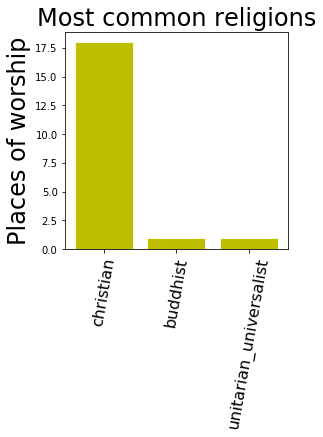

In [166]:
# Most common religions:

from pandas import DataFrame

sqlite_file = 'mountain_view.db'
conn = sqlite3.connect(sqlite_file)
c = conn.cursor()

pop_religion = cur.execute('SELECT nodes_tags.value, COUNT(*) as num \
            FROM nodes_tags \
                JOIN (SELECT DISTINCT(id) FROM nodes_tags WHERE value="place_of_worship") i \
                ON nodes_tags.id=i.id \
            WHERE nodes_tags.key="religion" \
            GROUP BY nodes_tags.value \
            ORDER BY num DESC \
            LIMIT 10;')
df_religion = DataFrame(pop_religion.fetchall())
df_religion.rename(columns={0: 'Religion', 1: 'Count'}, inplace=True)
df_religion

#Plot the data:

labels = list(df_religion['Religion'])
fig, ax = plt.subplots(figsize=(4,4))
ind = np.arange(3)
religion_count = ax.bar(ind, df_religion['Count'], width =0.8, color='y', edgecolor='w', linewidth=0.8)
ax.set_xticks(ind)
ax.set_xticklabels(labels, rotation = 80, size = 16)
plt.title('Most common religions', size = 24); plt.ylabel('Places of worship', size = 24);

This graph seem to me lacking other religions and places of worship. 
After researching a bit I found that there is a Muslim place of worship in Mountain View that is not mentioned in the OSM.
Nevertheless, I verified that there are 18 different churches in Mountain View with a simple Google search, which is the same number as in the OSM file I am working on and the one from the plot above. This means that the data does represent correctly the actual places of worship in Mountain View, with one exception.

            Cuisine  Count
0            indian     14
1          japanese     13
2             pizza     12
3           chinese     10
4           mexican     10
5     mediterranean      5
6             sushi      5
7          american      4
8             Asian      4
9        vietnamese      4
10           burger      3
11         sandwich      3
12             thai      3
13         barbecue      2
14          italian      2
15           korean      2
16  american;indian      1
17           bagels      1
18      boba;snacks      1
19        breakfast      1


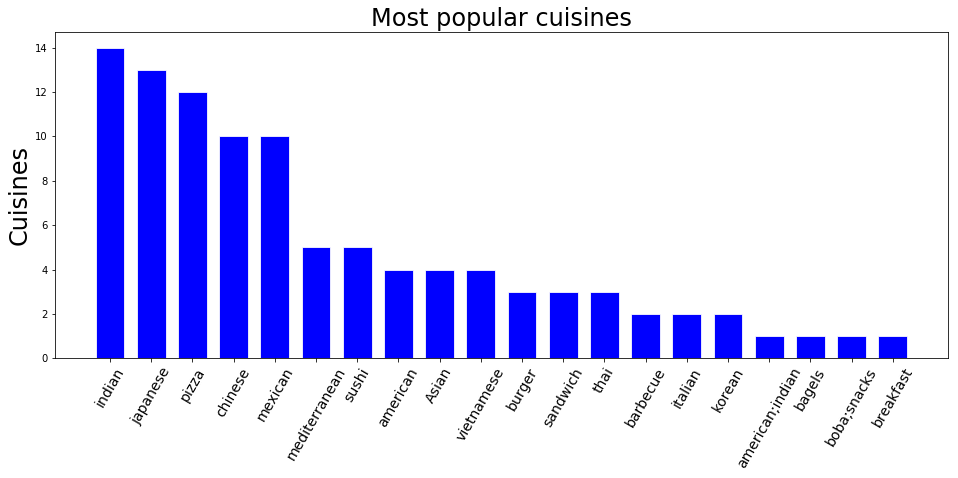

In [177]:
# Most popular cuisines

from pandas import DataFrame

sqlite_file = 'mountain_view.db'
conn = sqlite3.connect(sqlite_file)
c = conn.cursor()

pop_cuisine = cur.execute('SELECT nodes_tags.value, COUNT(*) as num \
FROM nodes_tags \
JOIN (SELECT DISTINCT(id) FROM nodes_tags WHERE value="restaurant") i \
ON nodes_tags.id=i.id \
WHERE nodes_tags.key="cuisine" \
GROUP BY LOWER(nodes_tags.value) \
ORDER BY num DESC limit 20')
df_cuisine = DataFrame(pop_cuisine.fetchall())
df_cuisine.rename(columns={0: 'Cuisine', 1: 'Count'}, inplace=True)
print(df_cuisine)

#Plot the data:

labels = list(df_cuisine['Cuisine'])

fig, ax = plt.subplots(figsize=(16,6))
ind = np.arange(20)
ax.bar(ind, df_cuisine['Count'], width =0.7, color='b', edgecolor='w', linewidth=0.8)
ax.set_xticks(ind)
ax.set_xticklabels(labels, rotation = 60, size = 14)
plt.title('Most popular cuisines', size = 24); plt.ylabel('Cuisines', size = 24);

Some records above repeat themselves, like Asian and asian, or Mexican and mexican. The solution was to group by LOWER caps with SQL, which make all appearences of the same tag become low caps and thus count them together.

            Amenity  Count
0   bicycle_parking    238
1             bench    163
2        restaurant    122
3              cafe     60
4         fast_food     36
5          post_box     33
6    drinking_water     29
7  parking_entrance     27
8          fountain     25
9           dentist     23


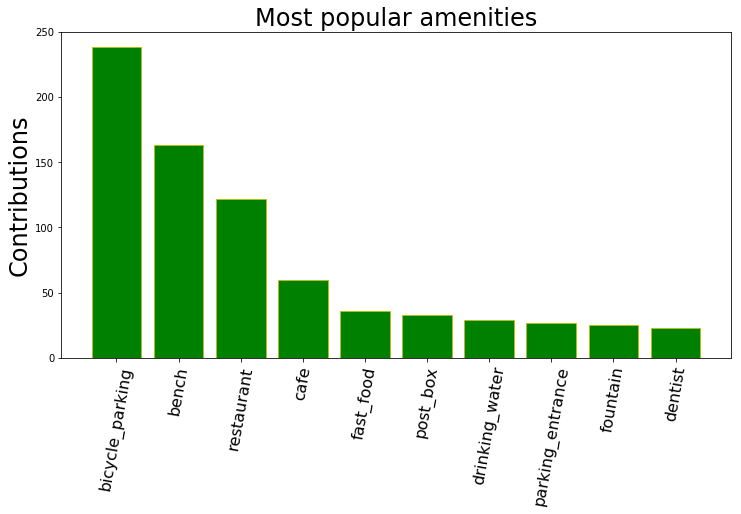

In [151]:
# Amenities

from pandas import DataFrame

sqlite_file = 'mountain_view.db'
conn = sqlite3.connect(sqlite_file)
c = conn.cursor()

pop_amenity = cur.execute('SELECT value, COUNT(*) as num \
            FROM nodes_tags WHERE key="amenity" \
            GROUP BY value \
            ORDER BY num DESC \
            LIMIT 10;')
df_amenity = DataFrame(pop_amenity.fetchall())
df_amenity.rename(columns={0: 'Amenity', 1: 'Count'}, inplace=True)
pprint.pprint(df_amenity)

# Draw a plot

import matplotlib.pyplot as plt
import numpy as np

labels = list(df_amenity['Amenity'])

fig, ax = plt.subplots(figsize=(12,6))
ind = np.arange(10)
ax.bar(ind, df_amenity['Count'], width =0.8, color='g', edgecolor='y', linewidth=0.8)
ax.set_xticks(ind)
ax.set_xticklabels(labels, rotation = 80, size = 16)
plt.title('Most popular amenities', size = 24); plt.ylabel('Contributions', size = 24);

               User  Number of mentions
0            ediyes               89663
1          karitotp               83232
2          RichRico               46628
3         calfarome               44133
4            samely               43585
5         dannykath               33749
6       Harry Cutts               29162
7         Luis36995               22046
8             Rub21               21448
9         matthieun               17307
10            osmsf               16592
11            mk408               15531
12  nikhilprabhakar               13623
13            Apo42               12585
14              n76               10074
15      KindredCoda                6599
16     CoreyFarwell                6009
17           dbaupp                5984
18            beddy                5953
19         oldtopos                5158


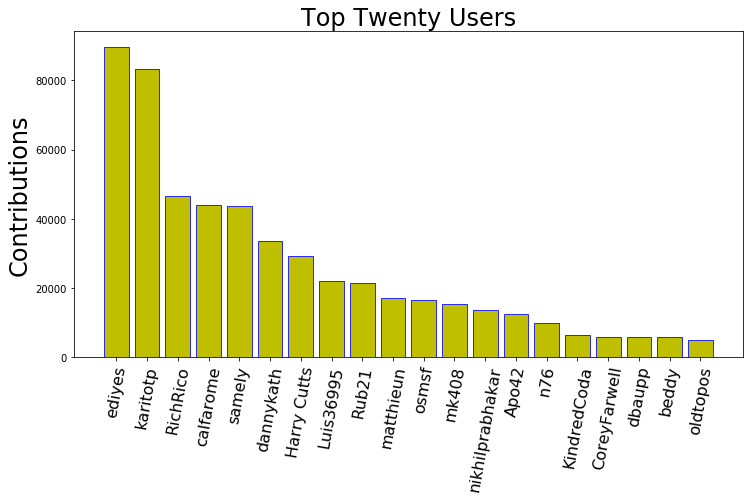

In [150]:
# Users Contributions

from pandas import DataFrame

sqlite_file = 'mountain_view.db'
conn = sqlite3.connect(sqlite_file)
c = conn.cursor()

users = cur.execute('SELECT editer.user, count(*) as edits FROM \
(SELECT user FROM nodes \
 UNION ALL SELECT user FROM ways \
 UNION ALL SELECT user FROM nodes) as editer \
 GROUP BY editer.user \
 ORDER BY edits DESC \
 LIMIT 20')
df_users = DataFrame(users.fetchall())
df_users.rename(columns={0: 'User', 1: 'Number of mentions'}, inplace=True)
print(df_users)

labels = list(df_users['User'])

fig, ax = plt.subplots(figsize=(12,6))
ind = np.arange(20)
ax.bar(ind, df_users['Number of mentions'], width =0.8, color='y', edgecolor='b', linewidth=0.8)
ax.set_xticks(ind)
ax.set_xticklabels(labels, rotation = 80, size = 16)
plt.title('Top Twenty Users', size = 24); plt.ylabel('Contributions', size = 24);

<a id="conclusion" name=""></a>
# Conclusion
<a href="#top">Top</a>

This project was a great learning and practising data wrangling experience. I loved learning interesting facts about my city, like the fact that there is not one synagogue (compare to 3 in the neighbouring city of Palo Alto), and confirm things that I already knew, like the spread of Christian worship places.<br />

The Mountain View XML file with all its human-inserted data proved to be fairly complete one. For example, only 14 records were found with corrupted street names, of which 4 were false/negative cases. The same thing goes to the zip codes, where only 4 records were found to be wrong Mountain View zip codes, out of a couple of thousands found in the dataset.
Despite the fact that we saw only 3 different types of religion dominations places in Mountain View, this city's cultural diversity is much more colourful and flavorful, as it seen under the "Cuisine" analysis above. Indian restaurants, Japanese, Chinese, Pizza and Mexican can be found everywhere around the city and are the most popular. Even more than burger places, or American restaurants.


It seems that some users contributed an in-humane amount of data. For example, "ediyes" contributed 89,663 tags within the Nodes and Ways tags. The reason is that those users with that amount of data inserted are in actuality bots, which are operated by volunteers who wrote those scripts in order to reduce handwork, save time and increase accuracy. It works! The Mountain View OSM map has very few men made errors.

# Other ideas and improvements

#### Prevent Typos
A good way to prevent typos in streets and street types can be a function that checks every data inserted by the user and validates its accuracy. For example, if a user inserts "Mont Blanc Rd.", the function will recognize the incomplete suffix of the street name and automatically correct it to "Road". Just like we did in the above code of the street names and zip codes, using mapping.
What can go wrong with this typos-prevention method is suffixes that the system does not recognize as ones, thus not correcting them when there are human errors with those unknown suffixes. So, it won't fix everything all the time. The positive thing here is that with time more and more suffixes will be added to the OSM database, so the auto-correction will improve.

#### Lowercase them all!
Another improvement can be done on the Open Street Map code to make all certain tags' values (for example, the tag "Cuisine", as shown above under "Most Popular Cuisine" code snippet) uppercase or lowercase, but not mixed. This can save work to the analyst using the data.
An interesting point to think about is if this improvement is necessary for other languages and how well it will fit ones that are not Latin. Maybe there is no need for that functionality with other languages at all.
Another point to think about here is the visibility of the data to the end user. It is much easier to recognize and understand the meaning of a word that is capitalized since they can suggest a proper noun names, a specific person, or a place. To do that in the code above it is easy as changing the LOWER SQL command to UPPER. Naturally, the better solution would be to work on this issue on the OSM code itself, so when it gets to the users, it is already uniformed.